# Van der Pol Oscillator

This example demonstrates how to find a Koopman model for the Van der Pol Oscillator system.

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

import pykoop
import pykoop.dynamic_models

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_vdp()

Create the Koopman pipeline. It accepts a list of lifting functions, which are composed to form the final transformation. Each lifting function has a string name, which can be used for cross-validating over lifting function parameters.

Here, the lifting function is all third-order polynomials of the state, while the input is left unlifted. Try changing `order=3` to something lower, and see how the prediction changes.

In [3]:
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'sp',
        pykoop.SplitPipeline(
            lifting_functions_state=[
                ('pl', pykoop.PolynomialLiftingFn(order=3))
            ],
            lifting_functions_input=None,
        ),
    )],
    regressor=pykoop.Edmd(),
)

Fit the pipeline. The data format consists of an optional episode feature, which groups individual experiments, states, and exogenous inputs. The `fit()` method needs to know if there is an episode feature, and how many inputs there are.

In [4]:
kp.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)

KoopmanPipeline(lifting_functions=[('sp',
                                    SplitPipeline(lifting_functions_state=[('pl',
                                                                            PolynomialLiftingFn(order=3))]))],
                regressor=Edmd())

This is the matrix approximation of the Koopman operator. It needs to be transposed because `scikit-learn` puts time on the first axis and features on the second.

In [5]:
kp.regressor_.coef_.T

array([[ 1.00000000e+00,  1.00000000e-02,  2.11792118e-16,
        -1.35375177e-15,  3.05040281e-16, -4.08006962e-15,
         5.15082768e-15, -4.66683983e-15,  5.13478149e-16,
        -7.11517501e-15],
       [-1.00000000e-02,  1.02000000e+00,  3.42607887e-17,
        -2.17913795e-15,  5.27789618e-16,  1.79578574e-14,
        -2.00000000e-02, -2.60902411e-15,  4.88498131e-15,
         1.00000000e-02],
       [ 5.80923734e-15,  8.77347240e-15,  1.00000000e+00,
         2.00000000e-02,  1.00000000e-04, -1.72890944e-15,
        -1.82669093e-15,  8.50041608e-16, -9.17831349e-16,
         2.08374825e-15],
       [-2.24642775e-04,  4.76720354e-04, -1.17744010e-02,
         9.71702058e-01,  1.45186779e-02,  4.36227916e-05,
        -1.97478656e-04,  1.93634435e-04, -6.92106266e-05,
         4.40718826e-03],
       [-1.32490092e-03,  1.77917340e-03, -2.03118151e-02,
        -1.10639594e-01,  1.02761485e+00,  3.20797525e-04,
        -1.09988109e-03,  1.09564555e-03, -3.10453641e-04,
         2.

Predict using the fit pipeline twice: once by retracting and re-lifting the state between timesteps, and once retracting only at the end. Which one do you think will predict the system dynamics better?

In [6]:
# Predict with re-lifting between timesteps (default)
X_pred_local = kp.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
    relift_state=True,
)
# Predict without re-lifting between timesteps
X_pred_global = kp.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
    relift_state=False,
)

Plot both predictions.

Text(0.5, 1.0, 'True and predicted phase-space trajectories')

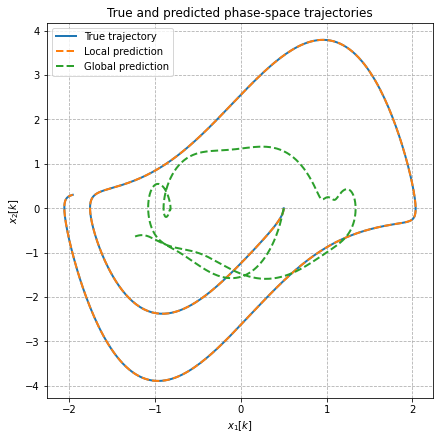

In [7]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
ax.plot(
    eg['X_valid'][:, 1],
    eg['X_valid'][:, 2],
    label='True trajectory',
)
ax.plot(
    X_pred_local[:, 1],
    X_pred_local[:, 2],
    '--',
    label='Local prediction',
)
ax.plot(
    X_pred_global[:, 1],
    X_pred_global[:, 2],
    '--',
    label='Global prediction',
)
ax.set_xlabel('$x_1[k]$')
ax.set_ylabel('$x_2[k]$')
ax.legend()
ax.set_title('True and predicted phase-space trajectories')

Now that we've seen the predictions in the state space, let's take a look at the lifted space. Predict again, but return the lifted states.

In [8]:
# Lift validation set
Psi_valid = kp.lift(eg['X_valid'])
# Predict lifted state with re-lifting between timesteps (default)
Psi_pred_local = kp.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
    relift_state=True,
    return_lifted=True,
    return_input=True,
)
# Predict lifted state without re-lifting between timesteps
Psi_pred_global = kp.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
    relift_state=False,
    return_lifted=True,
    return_input=True,
)

Plot each lifted state individually

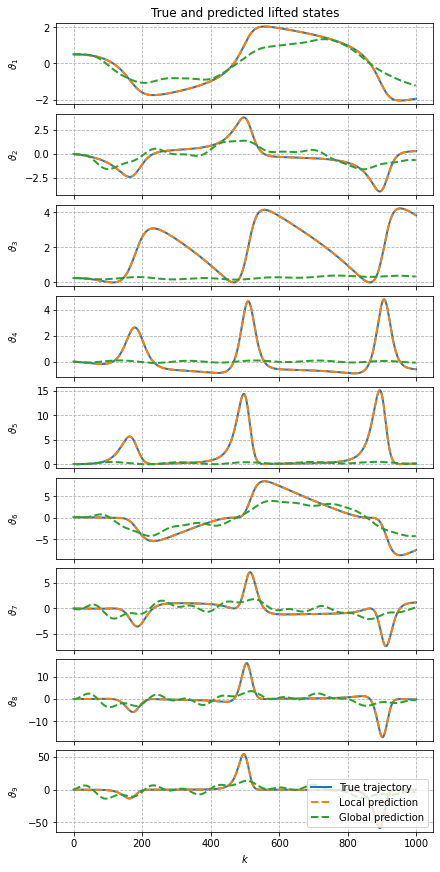

In [9]:
fig, ax = plt.subplots(
    kp.n_states_out_,
    1,
    constrained_layout=True,
    sharex=True,
    squeeze=False,
    figsize=(6, 12),
)
for i in range(ax.shape[0]):
    ax[i, 0].plot(
        Psi_valid[:, i + 1],
        label='True trajectory',
    )
    ax[i, 0].plot(
        Psi_pred_local[:, i + 1],
        '--',
        label='Local prediction',
    )
    ax[i, 0].plot(
        Psi_pred_global[:, i + 1],
        '--',
        label='Global prediction',
    )
    ax[i, 0].set_ylabel(rf'$\vartheta_{i + 1}$')

ax[-1, 0].set_xlabel('$k$')
ax[0, 0].set_title('True and predicted lifted states')
ax[-1, -1].legend(loc='lower right')
fig.align_ylabels()